## Anchor-based analysis
`%` of dataset that are solvable with certain group of patches

In [1]:
import json
import os
import pickle
import random
from functools import partial
from glob import glob

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as fv
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.patches as patches

from collections import defaultdict

sns.set()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)


### Helpers

In [2]:
dataset_names = [
    "imagenet_1k",
    "imagenet_1k_real",
    "imagenet_IN_plus_real",
    "imagenet_r",
    "imagenet_a",
    "imagenet_sketch",
    "objectnet",
]

model_names = ["resnet18", "resnet50", "vit32", "vgg16", "alexnet", "clip_vit_l_14"]

model_name_lookup = {
    "resnet18": "resnet18",
    "resnet50": "resnet50",
    "vit32": "vit_b_32",
    "vgg16": "vgg16",
    "alexnet": "alexnet",
    "clip_vit_l_14": "clip_vit_l_14"
}

pretty_model_names = {
    "resnet18": "ResNet-18",
    "resnet50": "ResNet-50",
    "vit32": "ViT-B/32",
    "vgg16": "VGG-16",
    "alexnet": "AlexNet",
    "clip_vit_l_14": "CLIP ViT-L/14"
}

pretty_dataset_names = {
    "imagenet_1k": "ImageNet",
    "imagenet_1k_real": "ImageNet ReaL",
    "imagenet_IN_plus_real": "ImageNet + ReaL",
    "imagenet_r": "ImageNet-R",
    "imagenet_a": "ImageNet-A",
    "imagenet_sketch": "ImageNet-Sketch",
    "objectnet": "ObjectNet",
}


### Load results

In [3]:
with open('../data/correctness.pkl', 'rb') as f:
    correctness_dfs = pickle.load(f)

## Classification Results

1. Standard 1-crop accuracy
2. Maximum possible accuracy

In [4]:
standard_accuracy = defaultdict(dict)
max_possible_accuracy = defaultdict(dict)

for dataset in dataset_names:
    for model in model_names:
        standard_accuracy[dataset][model] = 100* correctness_dfs[dataset][model].loc['LOC:1_1_Size:256'].mean()
        max_possible_accuracy[dataset][model]  = 100*np.mean(correctness_dfs[dataset][model].max(0))

In [5]:
s_acc_df = pd.DataFrame(standard_accuracy)
s_acc_df.index = [pretty_model_names[i] for i in s_acc_df.index]
s_acc_df.columns = [pretty_dataset_names[i] for i in s_acc_df.columns]
s_acc_df.round(2)

,ImageNet,ImageNet ReaL,ImageNet + ReaL,ImageNet-R,ImageNet-A,ImageNet-Sketch,ObjectNet
ResNet-18,69.45,76.94,76.47,32.14,1.37,19.41,27.59
ResNet-50,75.75,82.63,82.97,35.39,0.21,22.91,36.18
ViT-B/32,75.75,81.89,82.59,41.29,9.64,26.83,30.89
VGG-16,71.37,78.90,78.52,26.98,2.69,16.78,28.32
AlexNet,56.16,62.67,61.76,21.10,1.75,10.05,14.23
CLIP ViT-L/14,75.04,80.69,81.95,86.83,71.28,58.23,66.32


In [6]:
m_acc_df = pd.DataFrame(max_possible_accuracy)
m_acc_df.index = [pretty_model_names[i] for i in m_acc_df.index]
m_acc_df.columns = [pretty_dataset_names[i] for i in m_acc_df.columns]
m_acc_df.round(2)

,ImageNet,ImageNet ReaL,ImageNet + ReaL,ImageNet-R,ImageNet-A,ImageNet-Sketch,ObjectNet
ResNet-18,95.15,97.76,97.55,66.89,58.87,43.68,71.44
ResNet-50,96.78,98.62,98.57,68.84,66.68,47.64,76.83
ViT-B/32,97.19,98.75,98.91,75.58,78.03,55.99,79.28
VGG-16,95.30,97.90,97.66,60.88,58.27,39.90,71.85
AlexNet,90.03,93.85,93.48,55.52,42.23,29.53,59.65
CLIP ViT-L/14,96.78,98.70,98.80,99.20,98.49,89.00,93.13


### Load Min-Cover

In [7]:
# dump min covers to file

with open('../data/min_covers.pkl', 'rb') as f:
    min_covers = pickle.load(f)

## Analysis

In [8]:
# load preprocess anchor visibility data for each dataset
# here we show ImageNet-A as an example
with open("../data/all_visibility_data_imagenet_a.pickle", "rb") as f:
    anchor_visibility = pickle.load(f)

In [9]:
color_codes = [int(y * 255) for x in sns.color_palette(None, 9) for y in x]
color_codes = list(zip(*[iter(color_codes)] * 3))

vis_by_query = {
    x: pd.DataFrame.from_dict(anchor_visibility[x], orient="index")
    for x in range(len(anchor_visibility))
}

In [10]:
columns = model_correctness_pair['resnet18'].columns
columns = [int(x) for x in columns]

NameError: name 'model_correctness_pair' is not defined

In [ ]:
def get_vizcheck_by_anchor(anchor_loc, real_columns=columns):
    tdf = pd.concat([vis_by_query[i][anchor_loc] for i in range(7500)], axis=1)
    tdf.columns = tdf.columns.droplevel()
    tdf.columns = range(7500)
    tdf = tdf[real_columns]
    return tdf

In [ ]:
viz_loc_df = {}

for i in range(3):
    for j in range(3):
        viz_loc_df[(i, j)] = get_vizcheck_by_anchor((i, j))

In [ ]:
def show_accuracy(
    model_name, show_min_cover=False, min_covers=min_cover, tdf=viz_loc_df, pdf=None
):
    model_df = model_correctness_pair[model_name]
    model_df.columns = [int(x) for x in model_df.columns]
    grid_numbers = np.zeros((3, 3))

    if show_min_cover:
        index_cover = min_covers[model_name][0]
        model_df = model_df.loc[index_cover]

    list_acc = []

    for i in range(3):
        for j in range(3):
            if show_min_cover:
                list_acc.append(
                    100
                    * np.mean(
                        model_df[tdf[(i, j)].loc[index_cover]].fillna(False).max(0)
                    )
                )
            else:
                list_acc.append(
                    100 * np.mean(model_df[tdf[(i, j)]].fillna(False).max(0))
                )

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))

    for i in range(3):
        for j in range(3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            axes[i, j].text(0.3, 0.4, f"{round(list_acc[i*3+j], 2)}%", fontsize=18)
            grid_numbers[i, j] = list_acc[i * 3 + j]

    fig.suptitle(f"{model_name.capitalize()} - MinCover: {show_min_cover}")
    plt.tight_layout()
    if pdf:
        pdf.savefig(fig)
    return list_acc, grid_numbers, fig

,0,1,2
0,22.746667,27.720000,22.933333
1,28.706667,47.040000,27.906667
2,23.733333,28.653333,23.333333


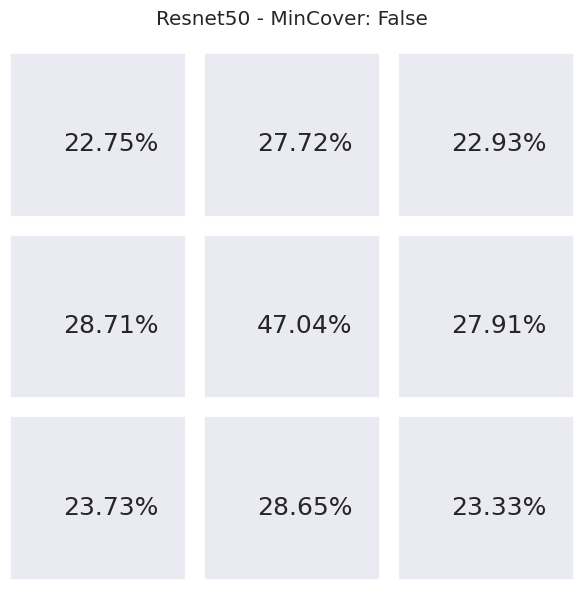

In [ ]:
R = show_accuracy("resnet50", show_min_cover=False)
pd.DataFrame(R[1])

,0,1,2
0,21.173333,26.773333,21.586667
1,27.573333,46.493333,26.573333
2,22.520000,27.613333,22.306667


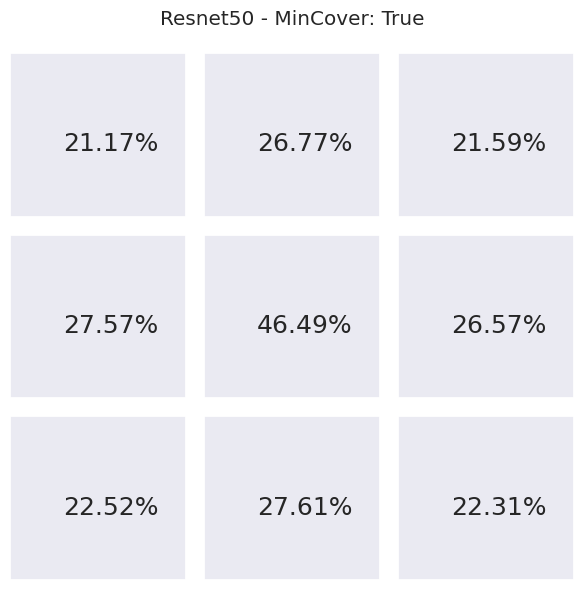

In [ ]:
R = show_accuracy("resnet50", show_min_cover=True)
pd.DataFrame(R[1])